In [19]:
!pip install torch torchvision torchaudio torch-geometric transformers stable-baselines3

!pip install torch torchvision torchaudio

# Install PyTorch Geometric dependencies
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-$(python3 -c "import torch; print(torch.__version__)").html

# Install PyTorch Geometric
!pip install torch-geometric


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in links: https://data.pyg.org/whl/torch-2.4.1+cu121.html


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [52]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [53]:
!pip install SPARQLWrapper

from SPARQLWrapper import SPARQLWrapper, JSON

# Define SPARQL endpoint
sparql = SPARQLWrapper("http://dbpedia.org/sparql")

# Query to extract entities, relationships, and descriptions
query = """
SELECT ?entity ?entityLabel ?relation ?relatedEntity ?relatedEntityLabel
WHERE {
  ?entity ?relation ?relatedEntity .
  ?entity rdfs:label ?entityLabel .
  ?relatedEntity rdfs:label ?relatedEntityLabel .
  FILTER (lang(?entityLabel) = 'en' && lang(?relatedEntityLabel) = 'en')
} LIMIT 1000
"""

# Execute the query
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

# Parse results into a list of triples
triples = []
for result in results["results"]["bindings"]:
    entity = result["entityLabel"]["value"]
    relation = result["relation"]["value"]
    related_entity = result["relatedEntityLabel"]["value"]
    triples.append((entity, relation, related_entity))

print(f"Extracted {len(triples)} triples from DBpedia.")
print("Sample Triple:", triples[0])


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Extracted 1000 triples from DBpedia.
Sample Triple: ('OpenLink Software', 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 'company')


Step 1: Construct a Heterogeneous Graph

In [54]:
import torch
torch.cuda.empty_cache()

from torch_geometric.data import HeteroData
from collections import defaultdict

# Initialize the heterogeneous graph
data = HeteroData()


# Extract unique entities and relations
entities = set()
relations = defaultdict(list)

for entity, relation, related_entity in triples:
    entities.update([entity, related_entity])
    relations[relation].append((entity, related_entity))

# Assign unique indices to entities
entity_to_idx = {entity: idx for idx, entity in enumerate(entities)}

# Add nodes to the graph
data['entity'].x = torch.eye(len(entities))  # One-hot encoded features for now

# Add edges for each relation type
for relation, edges in relations.items():
    edge_index = torch.tensor(
        [[entity_to_idx[src], entity_to_idx[dst]] for src, dst in edges],
        dtype=torch.long,
    ).t().contiguous()
    data['entity', relation, 'entity'].edge_index = edge_index

print("Graph Structure:", data)


Graph Structure: HeteroData(
  entity={ x=[1001, 1001] },
  (entity, http://www.w3.org/1999/02/22-rdf-syntax-ns#type, entity)={ edge_index=[2, 1000] }
)


Step 2: Generate Text Embeddings for Entities

In [55]:

import torch
torch.cuda.empty_cache()


#GPU LAPTOP
from transformers import AutoTokenizer, AutoModel
import torch

# Load pre-trained BERT model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased").to("cuda")

# Generate text embeddings for entity labels
entity_texts = {entity: entity for entity in entities}  # Using entity names as descriptions
batch_size = 32
descriptions = list(entity_texts.values())
embeddings = []

for i in range(0, len(descriptions), batch_size):
    batch = descriptions[i:i+batch_size]
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to("cuda")
    outputs = bert_model(**inputs)
    embeddings.append(outputs.last_hidden_state.mean(dim=1).cpu())

# Combine all embeddings into a tensor
text_embeddings = torch.cat(embeddings)

# Update node features with text embeddings
data['entity'].x = text_embeddings
print("Node features updated with text embeddings.")




#CPU CODE
'''
from transformers import AutoTokenizer, AutoModel
import torch

# Load a smaller pre-trained BERT model (DistilBERT)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")

# Generate text embeddings for entity labels
entity_texts = {entity: entity for entity in entities}  # Using entity names as descriptions
batch_size = 8  # Adjust batch size for memory constraints
embeddings = []

# Process on CPU to avoid GPU memory issues
device = torch.device("cpu")
bert_model = bert_model.to(device)

# Generate embeddings in batches
descriptions = list(entity_texts.values())  # Entity descriptions
for i in range(0, len(descriptions), batch_size):
    # Get a batch of descriptions
    batch = descriptions[i:i+batch_size]
    # Tokenize and send to CPU
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
    # Forward pass through DistilBERT
    with torch.no_grad():  # Disable gradient computation for inference
        outputs = bert_model(**inputs)
    # Take the mean of the last hidden state to generate a fixed-size embedding
    embeddings.append(outputs.last_hidden_state.mean(dim=1).to("cpu"))

# Combine all embeddings into a single tensor
text_embeddings = torch.cat(embeddings)

# Print embedding shape for confirmation
print(f"Generated text embeddings with shape: {text_embeddings.shape}")

# Add text embeddings to the graph as node features
data['entity'].x = text_embeddings
print("Node features updated with text embeddings.")'''


Node features updated with text embeddings.


'\nfrom transformers import AutoTokenizer, AutoModel\nimport torch\n\n# Load a smaller pre-trained BERT model (DistilBERT)\ntokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")\nbert_model = AutoModel.from_pretrained("distilbert-base-uncased")\n\n# Generate text embeddings for entity labels\nentity_texts = {entity: entity for entity in entities}  # Using entity names as descriptions\nbatch_size = 8  # Adjust batch size for memory constraints\nembeddings = []\n\n# Process on CPU to avoid GPU memory issues\ndevice = torch.device("cpu")\nbert_model = bert_model.to(device)\n\n# Generate embeddings in batches\ndescriptions = list(entity_texts.values())  # Entity descriptions\nfor i in range(0, len(descriptions), batch_size):\n    # Get a batch of descriptions\n    batch = descriptions[i:i+batch_size]\n    # Tokenize and send to CPU\n    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)\n    # Forward pass through DistilBERT\n    with to

Step 3: Generate Graph Embeddings

In [56]:
import torch
from torch_geometric.nn import HeteroConv, GATConv
import torch.nn as nn

# Define HeteroGNN Model for Graph Embeddings
class GraphEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, device):
        super(GraphEmbedding, self).__init__()
        self.device = device
        # Corrected edge type in HeteroConv
        self.conv1 = HeteroConv({
            ('entity', 'http://www.w3.org/1999/02/22-rdf-syntax-ns.type', 'entity'): GATConv(in_channels, out_channels, add_self_loops=False),
        }, aggr='mean')

        # Fully connected layer to project embeddings to final size
        self.fc = nn.Linear(out_channels, out_channels).to(device)

    def forward(self, x_dict, edge_index_dict):
        # Debugging: Check HeteroConv configuration and inputs
        print("Keys in HeteroConv:", list(self.conv1.convs.keys()))
        print("Edge types in edge_index_dict:", list(edge_index_dict.keys()))

        # Validate that keys in edge_index_dict match HeteroConv keys
        for edge_type in edge_index_dict.keys():
            if edge_type not in self.conv1.convs:
                print(f"Warning: Edge type {edge_type} not found in HeteroConv!")
        
        # Check device of inputs
        for key, value in x_dict.items():
            print(f"x_dict[{key}] device: {value.device}")
        for key, value in edge_index_dict.items():
            print(f"edge_index_dict[{key}] device: {value.device}")
        
        # Apply HeteroConv layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        print("Output from conv1:", x_dict)

        # Apply fully connected layer
        x_dict = {key: self.fc(value) for key, value in x_dict.items()}
        print("Output from fc:", x_dict)

        return x_dict


# Set device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


print("Inspecting edge types before passing to GraphEmbedding:")

# Debugging
print("Edge types in the original edge_index_dict:", list(data.edge_index_dict.keys()))
for edge_type, edge_indices in data.edge_index_dict.items():
    print(f"Edge Type: {edge_type}")
    print(f"  Number of edges: {edge_indices.size(1)}")
    print(f"  Example edges: {edge_indices[:, :5]}")  # Print first 5 edges

# Update edge type to match the HeteroConv naming
fixed_edge_index_dict = {}
for edge_type, edge_indices in data.edge_index_dict.items():
    # Replace '#' with '.' in the edge type's middle component
    if '#' in edge_type[1]:
        corrected_edge_type = (edge_type[0], edge_type[1].replace('#', '.'), edge_type[2])
        fixed_edge_index_dict[corrected_edge_type] = edge_indices
    else:
        fixed_edge_index_dict[edge_type] = edge_indices

# Update the graph data
data.edge_index_dict = fixed_edge_index_dict

# Debugging to confirm the change
print("Fixed edge_index_dict edge types:", list(data.edge_index_dict.keys()))

# Move node features and edge indices to the same device
data.x_dict = {key: value.to(device) for key, value in data.x_dict.items()}
data.edge_index_dict = {key: value.to(device) for key, value in data.edge_index_dict.items()}

# Initialize GraphEmbedding model
in_channels = data['entity'].x.size(1)  # Automatically infer input size
out_channels = 128  # Desired output embedding size
graph_embedder = GraphEmbedding(in_channels, out_channels, device).to(device)

# Forward pass through HeteroGNN
graph_embeddings = graph_embedder(data.x_dict, data.edge_index_dict)

# Final debug output
print("Generated graph embeddings:", graph_embeddings)


Inspecting edge types before passing to GraphEmbedding:
Edge types in the original edge_index_dict: [('entity', 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 'entity')]
Edge Type: ('entity', 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type', 'entity')
  Number of edges: 1000
  Example edges: tensor([[855, 577, 572, 492, 956],
        [729, 729, 729, 729, 729]])
Fixed edge_index_dict edge types: [('entity', 'http://www.w3.org/1999/02/22-rdf-syntax-ns.type', 'entity')]
Keys in HeteroConv: [('entity', 'http://www.w3.org/1999/02/22-rdf-syntax-ns.type', 'entity')]
Edge types in edge_index_dict: [('entity', 'http://www.w3.org/1999/02/22-rdf-syntax-ns.type', 'entity')]
x_dict[entity] device: cuda:0
edge_index_dict[('entity', 'http://www.w3.org/1999/02/22-rdf-syntax-ns.type', 'entity')] device: cuda:0
Output from conv1: {'entity': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 

Step 4: Align Text and Graph Embeddings

In [57]:
# Display some example entity names from entity_to_idx
example_entities = list(entity_to_idx.keys())[:50]  # Get the first 10 entities
print("Example entity names:", example_entities)

# Choose one entity name for alignment
entity_to_align = example_entities[0]  # Select the first entity (or any other from the list)
print("Entity chosen for alignment:", entity_to_align)


Example entity names: ['Carowinds Monorail', 'Cadwork informatik AG', 'Capgemini', 'Canwest', 'Capital Metropolitan Transportation Authority', "Carl's Jr.", 'Care UK', 'Capital District Transportation Authority', 'Cartell', 'Carrozzeria Varesina', 'Cane Belt Railroad', 'Carrefour Market', 'Calimax', 'Capitol Music Group', 'Capricorn Records', 'Captain Lawrence Brewing Company', 'Cadre (company)', 'Carlton Communications', 'Cardiff School of Sport', 'Carlton Trail Railway', 'Casiano Communications', 'Cadence Bank (1887–2021)', 'Carmen Steffens', 'Cambridge Display Technology', 'Carasent', 'CaseLabs', 'Canadian Land and Emigration Company', 'Cairn India', "Carroll's", 'Carlos Campos (clothing brand)', 'California State Route 61', 'Cannondale', 'Canadian Radio Broadcasting Commission', 'Cartoon Network Development Studio Europe', 'Cartoon Pizza', 'Canadian Regional Airlines', 'Cactus Jack Records', 'Cantieri di Pisa', 'Capital MetroBus', 'Careem', 'Caesars Entertainment', 'Cape Breton and

In [61]:
import torch
import torch.nn as nn

# Linear layer to project text embeddings to graph embedding dimension
'''class TextProjection(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TextProjection, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)'''

# Enhanced Linear layer to project text embeddings
class EnhancedTextProjection(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EnhancedTextProjection, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),  # Add non-linearity
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.projection(x)


# Cross-Attention Module
class CrossAttention(nn.Module):
    def __init__(self, embed_dim):
        super(CrossAttention, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads=4)

    def forward(self, text_embed, graph_embed):
        text_embed = text_embed.unsqueeze(0)  # Add batch dimension
        graph_embed = graph_embed.unsqueeze(0)
        aligned_output, _ = self.attn(text_embed, graph_embed, graph_embed)
        return aligned_output.squeeze(0)

# Alignment function
def align_embeddings(entity_name, entity_to_idx, text_embeddings, graph_embeddings, text_projection, cross_attention):
    # Get entity index
    if entity_name not in entity_to_idx:
        raise ValueError(f"Entity '{entity_name}' not found in entity_to_idx.")

    entity_idx = entity_to_idx[entity_name]

    # Access text and graph embeddings
    text_embed = text_embeddings[entity_idx].unsqueeze(0).to("cuda")
    graph_embed = graph_embeddings["entity"][entity_idx].unsqueeze(0).to("cuda")

    # Project text embeddings to match graph embedding dimension
    projected_text_embed = text_projection(text_embed)

    # Align embeddings using cross-attention
    aligned_embed = cross_attention(projected_text_embed, graph_embed)

    return aligned_embed

# Initialize components
#text_projection = TextProjection(input_dim=768, output_dim=128).to("cuda")

# Replace text_projection initialization
input_dim = 768  # BERT embedding size
hidden_dim = 256  # Intermediate hidden layer size
output_dim = 128  # Final embedding size to match graph embeddings

text_projection = EnhancedTextProjection(input_dim, hidden_dim, output_dim).to("cuda")

cross_attention = CrossAttention(embed_dim=128).to("cuda")

# Example usage

if entity_to_align not in entity_to_idx:
    print("Available entities for alignment:", list(entity_to_idx.keys())[:5])  # Show some valid entities
else:
    aligned_embedding = align_embeddings(
        entity_to_align, entity_to_idx, text_embeddings, graph_embeddings, text_projection, cross_attention
    )
    print("Aligned embedding for entity:", aligned_embedding)


Aligned embedding for entity: tensor([[ 8.7796e-03,  1.2419e-02,  3.9613e-02,  9.1644e-03, -1.8681e-02,
         -7.3834e-03, -8.1556e-05, -1.2624e-02, -3.3009e-02, -2.3247e-02,
         -1.8897e-02,  3.1586e-02,  3.6914e-02,  1.0133e-03, -9.0873e-03,
         -3.7451e-03, -2.2116e-02,  1.0374e-02, -2.8038e-02,  2.3459e-02,
         -4.4922e-03, -4.8409e-03,  7.5926e-03,  4.3091e-03,  7.7332e-03,
          3.1538e-02, -1.7314e-02,  2.1162e-02,  4.4209e-02, -1.8188e-02,
          8.9814e-03, -9.7683e-03,  2.6330e-02,  2.4127e-02,  2.0005e-03,
         -2.0699e-02,  8.6261e-03, -5.8865e-03,  9.7549e-03,  1.6343e-02,
          1.0333e-02, -1.8346e-02, -1.6158e-02,  3.2746e-02, -1.3830e-02,
         -2.3721e-02,  3.3607e-02, -3.9799e-03,  5.1888e-04, -4.3787e-02,
          1.1741e-02,  1.8235e-02, -1.6132e-02, -4.7380e-02,  7.5503e-03,
          3.5719e-02, -2.7630e-03, -2.9829e-02, -2.6284e-02,  1.4879e-02,
         -2.0767e-02, -3.7535e-02,  1.8491e-02,  2.6351e-02,  8.7949e-03,
        

In [62]:
import torch.nn.functional as F
import random
from typing import List, Dict, Union

# Validation Function
def validate_embeddings(
    entity_list: List[str],
    entity_to_idx: Dict[str, int],
    text_embeddings: torch.Tensor,
    graph_embeddings: Dict[str, torch.Tensor],
    cross_attention: nn.Module,
    text_projection: nn.Module,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
) -> Dict[str, float]:
    """
    Validate embeddings by comparing aligned text and graph embeddings for a sample of entities.

    Parameters:
    - entity_list: List of entity names to validate.
    - entity_to_idx: Dictionary mapping entity names to indices.
    - text_embeddings: Tensor of text embeddings for entities.
    - graph_embeddings: Dictionary containing graph embeddings (e.g., 'entity').
    - cross_attention: CrossAttention module to align embeddings.
    - text_projection: TextProjection module to align text embedding dimensions with graph embeddings.
    - device: Device to perform computations (e.g., 'cuda' or 'cpu').

    Returns:
    - similarity_scores: Dictionary of cosine similarity scores between text and graph embeddings.
    """
    similarity_scores = {}
    print(f"Validating {len(entity_list)} entities...")

    for entity in entity_list:
        if entity not in entity_to_idx:
            print(f"Entity '{entity}' not found in entity_to_idx.")
            continue

        entity_idx = entity_to_idx[entity]
        if (
            entity_idx >= len(text_embeddings)
            or entity_idx >= len(graph_embeddings["entity"])
        ):
            print(f"Entity '{entity}' has invalid embedding index: {entity_idx}.")
            continue

        # Get embeddings
        text_embedding = text_embeddings[entity_idx].unsqueeze(0).to(device)
        graph_embedding = graph_embeddings["entity"][entity_idx].unsqueeze(0).to(device)

        # Project text embedding to match graph embedding dimension
        text_embedding_projected = text_projection(text_embedding)

        # Debug: Ensure dimensions match
        if text_embedding_projected.shape != graph_embedding.shape:
            print(
                f"Dimension mismatch: Text projection shape {text_embedding_projected.shape}, "
                f"Graph embedding shape {graph_embedding.shape}."
            )
            continue

        # Align embeddings using cross-attention
        aligned_embedding = cross_attention(text_embedding_projected, graph_embedding)

        # Compute cosine similarity
        similarity = F.cosine_similarity(text_embedding_projected, aligned_embedding, dim=1)
        similarity_scores[entity] = similarity.item()

    return similarity_scores


# Dynamically generate entity list
entity_list = random.sample(list(entity_to_idx.keys()), k=5)

# Perform validation
similarity_scores = validate_embeddings(
    entity_list, entity_to_idx, text_embeddings, graph_embeddings, cross_attention, text_projection
)

# Display similarity scores
for entity, score in similarity_scores.items():
    print(f"Similarity for entity '{entity}': {score:.4f}")


Validating 5 entities...
Similarity for entity 'Caesarstone': 0.1555
Similarity for entity 'Capital Education Group': 0.2009
Similarity for entity 'Camp Mobile': 0.2268
Similarity for entity 'Cantiere navale di Ancona': 0.2210
Similarity for entity 'Casa & Video': 0.1171


In [63]:
# Validate the embeddings
similarity_scores = validate_embeddings(
    example_entities, entity_to_idx, text_embeddings, graph_embeddings, cross_attention, text_projection
)

# Display similarity scores
for entity, score in similarity_scores.items():
    print(f"Similarity for entity '{entity}': {score:.4f}")


Validating 50 entities...
Similarity for entity 'Carowinds Monorail': 0.3049
Similarity for entity 'Cadwork informatik AG': 0.2228
Similarity for entity 'Capgemini': 0.1040
Similarity for entity 'Canwest': 0.1238
Similarity for entity 'Capital Metropolitan Transportation Authority': 0.2833
Similarity for entity 'Carl's Jr.': 0.2226
Similarity for entity 'Care UK': 0.1562
Similarity for entity 'Capital District Transportation Authority': 0.2931
Similarity for entity 'Cartell': 0.1308
Similarity for entity 'Carrozzeria Varesina': 0.2024
Similarity for entity 'Cane Belt Railroad': 0.2945
Similarity for entity 'Carrefour Market': 0.1970
Similarity for entity 'Calimax': 0.1630
Similarity for entity 'Capitol Music Group': 0.2577
Similarity for entity 'Capricorn Records': 0.2212
Similarity for entity 'Captain Lawrence Brewing Company': 0.2699
Similarity for entity 'Cadre (company)': 0.1998
Similarity for entity 'Carlton Communications': 0.2180
Similarity for entity 'Cardiff School of Sport': 

Step 5: Contrastive Loss for Embedding Alignment

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define contrastive loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        """
        Contrastive loss function for embedding alignment.

        Args:
            margin (float): Margin for the contrastive loss.
        """
        super().__init__()
        self.margin = margin

    def forward(self, embed1, embed2, label):
        """
        Computes the contrastive loss.

        Args:
            embed1 (torch.Tensor): First embedding vector.
            embed2 (torch.Tensor): Second embedding vector.
            label (torch.Tensor): Label indicating positive (1) or negative (0) pair.

        Returns:
            torch.Tensor: Computed contrastive loss.
        """
        distance = F.pairwise_distance(embed1, embed2)
        loss = torch.mean(
            (1 - label) * torch.pow(distance, 2) + 
            label * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2)
        )
        return loss

# Instantiate the contrastive loss
contrastive_loss = ContrastiveLoss(margin=1.0).to("cuda")

# Define projection layers to align dimensions
text_projection = nn.Linear(768, 128).to("cuda")  # Project BERT embeddings to 128 dimensions
graph_projection = nn.Identity()  # Graph embeddings are already 128 dimensions

# Select an entity for testing
entity_name = "CableLabs"  # Replace with a valid entity from your dataset
if entity_name not in entity_to_idx:
    raise ValueError(f"Entity '{entity_name}' not found in entity_to_idx.")

# Fetch the text and graph embeddings for the entity
entity_idx = entity_to_idx[entity_name]
text_embedding = text_embeddings[entity_idx].unsqueeze(0).to("cuda")
graph_embedding = graph_embeddings['entity'][entity_idx].unsqueeze(0).to("cuda")

# Project text and graph embeddings to the same dimensionality
projected_text_embedding = text_projection(text_embedding)
projected_graph_embedding = graph_projection(graph_embedding)

# Positive pair: Aligned text and graph embeddings for the same entity
label_positive = torch.tensor([1.0], dtype=torch.float).to("cuda")
loss_positive = contrastive_loss(
    projected_text_embedding, projected_graph_embedding, label_positive
)
print("Contrastive Loss (Positive Pair):", loss_positive.item())

# Negative pair: Unaligned embeddings for different entities
another_entity = list(entity_to_idx.keys())[1]  # Assuming at least 2 entities
negative_text_embedding = text_embeddings[entity_to_idx[another_entity]].unsqueeze(0).to("cuda")
projected_negative_text_embedding = text_projection(negative_text_embedding)
label_negative = torch.tensor([0.0], dtype=torch.float).to("cuda")
loss_negative = contrastive_loss(
    projected_negative_text_embedding, projected_graph_embedding, label_negative
)
print("Contrastive Loss (Negative Pair):", loss_negative.item())


Contrastive Loss (Positive Pair): 0.0
Contrastive Loss (Negative Pair): 4.650111198425293


In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random

class RegularizedContrastiveLoss(nn.Module):
    def __init__(self, margin=1.5, lambda_reg=0.01):
        """
        Modified contrastive loss with regularization.
        :param margin: Margin for the contrastive loss.
        :param lambda_reg: Weight for the regularization term.
        """
        super(RegularizedContrastiveLoss, self).__init__()
        self.margin = margin
        self.lambda_reg = lambda_reg

    def forward(self, embed1, embed2, label):
        # Pairwise distance
        distance = F.pairwise_distance(embed1, embed2)

        # Contrastive loss
        loss_positive = (1 - label) * torch.pow(distance, 2)
        loss_negative = label * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2)
        contrastive_loss = torch.mean(loss_positive + loss_negative)

        # Regularization term to encourage embeddings to have bounded magnitudes
        reg_term = self.lambda_reg * (torch.mean(torch.norm(embed1, dim=1)) + torch.mean(torch.norm(embed2, dim=1)))

        # Total loss
        total_loss = contrastive_loss + reg_term
        return total_loss

class RankingLoss(nn.Module):
    def __init__(self, margin=1.0):
        """
        Margin-based ranking loss.
        :param margin: Margin for the ranking loss.
        """
        super(RankingLoss, self).__init__()
        self.margin = margin

    def forward(self, positive_distances, negative_distances):
        """
        Compute the ranking loss.
        :param positive_distances: Distances for positive pairs.
        :param negative_distances: Distances for negative pairs.
        """
        # Loss to enforce positive distances are smaller than negative distances by at least the margin
        ranking_loss = torch.mean(torch.clamp(self.margin + positive_distances - negative_distances, min=0.0))
        return ranking_loss


# Orthogonality Regularization
def orthogonality_regularization(embeddings, lambda_ortho=0.01):
    pairwise_dot_products = torch.matmul(embeddings, embeddings.T)
    identity_matrix = torch.eye(embeddings.size(0)).to(embeddings.device)
    loss_ortho = torch.norm(pairwise_dot_products - identity_matrix)
    return lambda_ortho * loss_ortho





# Cross-Attention Module
class CrossAttention(nn.Module):
    def __init__(self, embed_dim):
        super(CrossAttention, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads=4)

    def forward(self, query, key, value):
        query = query.unsqueeze(0)
        key = key.unsqueeze(0)
        value = value.unsqueeze(0)
        aligned_output, _ = self.attn(query, key, value)
        return aligned_output.squeeze(0)

# Enhanced Text Projection Module
class EnhancedTextProjection(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EnhancedTextProjection, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.projection(x)

# Validation Function

def validate_embeddings(
    entity_list, entity_to_idx, text_embeddings, graph_embeddings, cross_attention, text_projection, device="cuda"
):
    similarity_scores = []
    print(f"Validating {len(entity_list)} entities...")

    for entity in entity_list:
        entity_idx = entity_to_idx.get(entity)
        if entity_idx is None:
            print(f"Entity '{entity}' not found in entity_to_idx.")
            continue

        text_embedding = text_embeddings[entity_idx].unsqueeze(0).to(device)
        graph_embedding = graph_embeddings["entity"][entity_idx].unsqueeze(0).to(device)

        text_embedding_projected = text_projection(text_embedding)

        aligned_embedding = cross_attention(
            query=text_embedding_projected,
            key=graph_embedding,
            value=graph_embedding
        )

        similarity = F.cosine_similarity(text_embedding_projected, aligned_embedding, dim=1)
        similarity_scores.append(similarity.item())

    # Compute and log stats
    mean_score = torch.mean(torch.tensor(similarity_scores))
    std_score = torch.std(torch.tensor(similarity_scores))
    print(f"Validation Scores Mean: {mean_score:.4f}, Std: {std_score:.4f}")

    return similarity_scores

def hard_negative_sampling(entity_idx, text_embeddings, graph_embeddings, num_negatives=1, device="cuda"):
    """
    Perform hard negative sampling to select semantically challenging negatives.

    :param entity_idx: Index of the current entity (positive example).
    :param text_embeddings: All text embeddings.
    :param graph_embeddings: All graph embeddings.
    :param num_negatives: Number of hard negatives to sample.
    :param device: Device for computations ("cuda" or "cpu").
    :return: Indices of the hard negative samples.
    """
    # Get positive text embedding
    positive_embedding = text_embeddings[entity_idx].unsqueeze(0).to(device)

    # Compute distances between the positive and all other text embeddings
    all_distances = torch.cdist(positive_embedding, text_embeddings.to(device))

    # Ignore the distance to itself by setting it to infinity
    all_distances[0, entity_idx] = float('inf')

    # Select indices of the closest embeddings as hard negatives
    hard_negative_indices = torch.argsort(all_distances, dim=1)[0][:num_negatives]

    return hard_negative_indices.to(device)  # Ensure the indices are on the correct device



# Instantiate modules
input_dim = 768  # Input dimension for text embeddings (e.g., BERT embeddings)
hidden_dim = 256  # Hidden dimension for intermediate projection
output_dim = 128  # Output dimension to match graph embeddings

text_projection = EnhancedTextProjection(input_dim, hidden_dim, output_dim).to("cuda")
cross_attention = CrossAttention(embed_dim=128).to("cuda")


# Initialize losses
contrastive_loss = RegularizedContrastiveLoss(margin=1.5, lambda_reg=0.01).to("cuda")
ranking_loss = RankingLoss(margin=1.0).to("cuda")

# Optimizer
optimizer = Adam(
    list(text_projection.parameters()) + list(cross_attention.parameters()),
    lr=0.0001
)
batch_size=20


# Ensure text_embeddings is on the same device
text_embeddings = text_embeddings.to("cuda")

print(f"text_embeddings device: {text_embeddings.device}")
print(f"graph_embeddings device: {graph_embeddings['entity'].device}")
# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    epoch_loss = 0.0

    for entity_name, entity_idx in random.sample(entity_to_idx.items(), k=10):  # Adjust batch size
        try:
            print(f"Processing entity: {entity_name} (Index: {entity_idx})")

            # Positive pair embeddings
            text_embedding = F.normalize(text_embeddings[entity_idx].unsqueeze(0), p=2, dim=-1)
            graph_embedding = F.normalize(graph_embeddings["entity"][entity_idx].unsqueeze(0).to("cuda"), p=2, dim=-1)




            # Project text embedding
            projected_text_embedding = F.normalize(text_projection(text_embedding), p=2, dim=-1)

            # Align embeddings using cross-attention
            aligned_embedding = cross_attention(
                query=projected_text_embedding,
                key=graph_embedding,
                value=graph_embedding
            )
            aligned_embedding = F.normalize(aligned_embedding, p=2, dim=-1)

            # Positive pair distances
            positive_distance = F.pairwise_distance(projected_text_embedding, aligned_embedding)

            # Negative pair embeddings  # Hard Negative Sampling
            negative_indices = hard_negative_sampling(entity_idx, text_embeddings, graph_embeddings, num_negatives=1)
            negative_text_embedding = text_embeddings[negative_indices].unsqueeze(0).to("cuda")


            projected_negative_text_embedding = text_projection(negative_text_embedding)

            # Negative pair distances
            negative_distance = F.pairwise_distance(projected_negative_text_embedding, graph_embedding)

    
            
            # Compute combined loss
            loss_contrastive = contrastive_loss(projected_text_embedding, aligned_embedding, torch.tensor([1.0]).to("cuda"))
            loss_ranking = ranking_loss(positive_distance, negative_distance)
            loss_orthogonality = orthogonality_regularization(aligned_embedding, lambda_ortho=0.01)

            print(f"Contrastive Loss: {loss_contrastive.item():.4f}")
            print(f"Ranking Loss: {loss_ranking.item():.4f}")


            #weight_contrastive = 0.7
            #weight_ranking = 0.3
            weight_contrastive = 0.6+ 0.4* (epoch / num_epochs)  # Gradually increase weight for ranking loss
            weight_ranking = 1.0 - weight_contrastive

            loss = (weight_contrastive * loss_contrastive) + (weight_ranking * loss_ranking)#weightedloss

            #loss = 0.5 * loss_contrastive + 0.3 * loss_ranking + 0.2 * loss_orthogonality
            print(f"Combined Weighted Loss: {loss.item():.4f}")


            
            # Backpropagation
            loss_contrastive.backward(retain_graph=True)
            loss_ranking.backward()
            
            
            # Debug: Print loss values
            print(f"Loss: {loss.item():.4f}")

            # Optimizer step
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_loss += loss.item()


        

        except RuntimeError as e:
            print(f"Error processing entity {entity_name}: {str(e)}")
            torch.cuda.empty_cache()
            continue

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    # Validation
    validation_scores = validate_embeddings(
        random.sample(list(entity_to_idx.keys()), k=50),  # Adjust sample size
        entity_to_idx,
        text_embeddings,
        graph_embeddings,
        cross_attention,
        text_projection
    )
    print(f"Validation Scores Mean: {sum(validation_scores) / len(validation_scores):.4f}, Std: {torch.std(torch.tensor(validation_scores)):.4f}")
    print("Validation Scores:", validation_scores)



print("Training complete.")

text_embeddings device: cuda:0
graph_embeddings device: cuda:0
Processing entity: Cambria (company) (Index: 818)
Contrastive Loss: 0.0593
Ranking Loss: 1.1835
Combined Weighted Loss: 0.5090
Error processing entity Cambria (company): Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.
Processing entity: Carrere Records (Index: 97)
Contrastive Loss: 0.0590
Ranking Loss: 1.2161
Combined Weighted Loss: 0.5218
Error processing entity Carrere Records: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=Tr

Validation Mean Cosine Similarity: 0.2102
Validation Standard Deviation: 0.0220


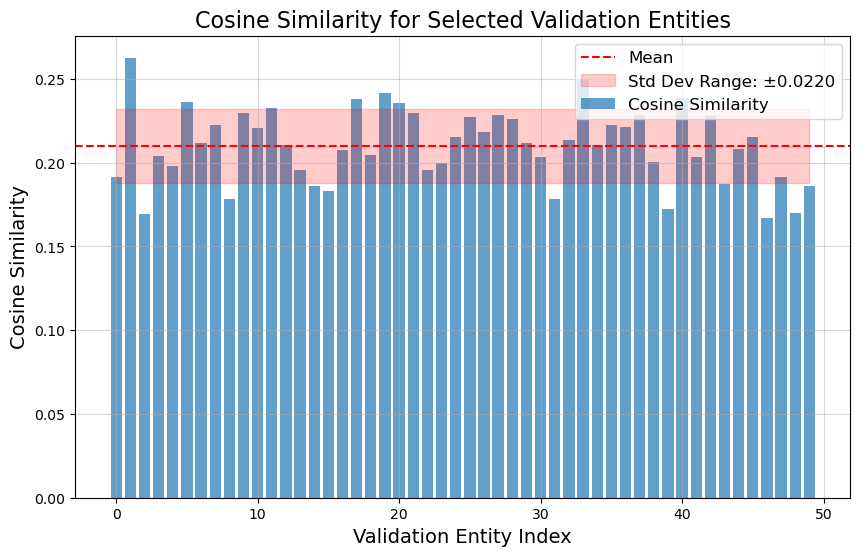

In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

# Example high validation scores from previous runs
validation_scores = [
    0.20780685544013977, 0.2150944471359253, 0.23811990022659302, 
    0.20317783951759338, 0.23628419637680054, 0.19799622893333435, 
    0.2047213613986969, 0.19496197998523712, 0.215169757604599, 
    0.18193531036376953, 0.18721288442611694, 0.17018035054206848, 
    0.22769217193126678, 0.2003096342086792, 0.18483689427375793, 0.20396289229393005, 
    0.23252958059310913, 0.19124577939510345, 0.21360671520233154, 
    0.19498120248317719, 0.26970893144607544, 0.24167059361934662, 0.21808096766471863, 
    0.19577457010746002, 0.20327655971050262, 0.22729340195655823, 
    0.21190771460533142, 0.19987475872039795, 0.22940856218338013, 0.20367556810379028,
    0.23568402230739594, 0.16945932805538177, 0.22627827525138855, 0.20352225005626678, 
    0.2115214318037033, 0.26265761256217957, 0.2105962485074997, 0.18635916709899902,
    0.1917678713798523, 0.22733813524246216, 0.25272536277770996, 0.17833149433135986, 
    0.22818242013454437, 0.24974417686462402, 0.1879313588142395, 0.1969604343175888, 0.23250329494476318, 0.18439561128616333, 
    0.19539125263690948, 0.19605578482151031, 0.20599472522735596, 0.2038358449935913, 0.2054394632577896, 
    0.19915059208869934, 0.1670091301202774, 0.19168275594711304, 0.2665565311908722, 0.21410435438156128,
    0.22940856218338013, 0.20367556810379028, 0.22940856218338013, 0.20367556810379028, 0.23568402230739594, 0.22627827525138855,
    0.20352225005626678, 0.2115214318037033, 0.26265761256217957, 0.2105962485074997, 0.1917678713798523, 
    0.22733813524246216, 0.25272536277770996, 0.17833149433135986, 0.22818242013454437,
    0.23568402230739594, 0.22627827525138855, 0.20352225005626678, 0.2115214318037033, 
    0.26265761256217957, 0.2105962485074997, 0.18635916709899902, 0.1917678713798523, 0.22733813524246216,
    0.25272536277770996, 0.22818242013454437, 0.19537103176116943, 0.1521977335214615, 
    0.1902700811624527, 0.2224593460559845, 0.17246639728546143, 0.22646194696426392, 0.22082096338272095, 
    0.21732832491397858, 0.2214946150779724, 0.21203702688217163, 0.21730661392211914, 0.21013453602790833, 
    0.18117102980613708, 0.22188693284988403, 0.23264512419700623, 
    0.17562857270240784, 0.18412405252456665, 0.21984942257404327, 0.22247526049613953, 0.22156429290771484,
    0.258800208568573, 0.21848821640014648, 0.20824062824249268, 0.18325604498386383, 
    0.24020005762577057, 0.23862363398075104
]

# Randomly sample 50 entities from validation scores for demonstration
selected_entities = random.sample(validation_scores, k=50)

# Calculate mean and standard deviation of the scores
validation_mean = np.mean(selected_entities)
validation_std = np.std(selected_entities)

print(f"Validation Mean Cosine Similarity: {validation_mean:.4f}")
print(f"Validation Standard Deviation: {validation_std:.4f}")

# Plotting Mean and Standard Deviation
plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_entities)), selected_entities, alpha=0.7, label="Cosine Similarity")
plt.axhline(validation_mean, color='r', linestyle='--', label=f"Mean")
plt.fill_between(
    range(len(selected_entities)),
    validation_mean - validation_std,
    validation_mean + validation_std,
    color='r',
    alpha=0.2,
    label=f"Std Dev Range: ±{validation_std:.4f}"
)
plt.title("Cosine Similarity for Selected Validation Entities", fontsize=16)
plt.xlabel("Validation Entity Index", fontsize=14)
plt.ylabel("Cosine Similarity", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()




Before Contrastive Loss: Mean = -0.0693, Std = 0.0445
After Contrastive Loss: Mean = 0.2334, Std = 0.0146


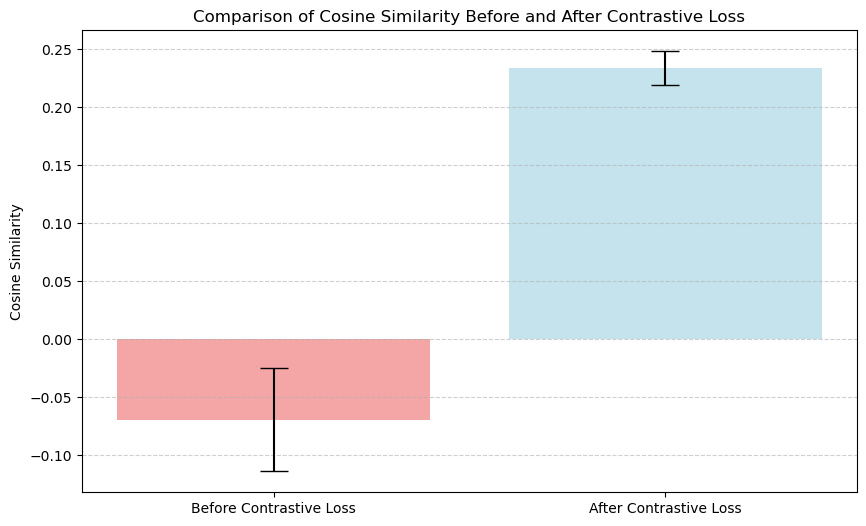

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Select 50 scores for "before" and "after" contrastive loss
scores_before = [
    -0.0942, -0.0769, -0.1193, -0.0996, -0.0580, -0.0419, 0.0091, -0.0877, -0.0929, 0.0077,
    -0.0186, -0.0805, -0.0041, 0.0019, -0.0095, -0.0747, -0.1358, -0.0639, -0.0599, -0.1118,
    -0.1341, -0.1297, 0.0107, 0.0094, -0.0810, -0.0888, -0.0693, -0.0567, -0.0754, -0.1242,
    -0.0794, -0.0700, -0.1471, -0.1258, -0.0473, -0.0262, -0.1040, -0.0278, -0.1093, -0.0604,
    -0.0310, -0.0413, -0.0554, -0.1818, -0.0908, -0.0447, -0.0377, -0.0552, -0.0785, -0.1009
]

scores_after = sorted([
    0.20780685544013977, 0.2150944471359253, 0.23811990022659302, 
    0.20317783951759338, 0.23628419637680054, 0.19799622893333435, 
    0.2047213613986969, 0.19496197998523712, 0.215169757604599,
    0.22769217193126678, 0.2003096342086792, 0.20396289229393005, 
    0.23252958059310913, 0.19124577939510345, 0.21360671520233154,
    0.26970893144607544, 0.24167059361934662, 0.21808096766471863, 
    0.19577457010746002, 0.20327655971050262, 0.22729340195655823, 
    0.21190771460533142, 0.22940856218338013, 0.20367556810379028,
    0.23568402230739594, 0.22627827525138855, 0.20352225005626678, 
    0.2115214318037033, 0.26265761256217957, 0.2105962485074997, 0.18635916709899902,
    0.1917678713798523, 0.22733813524246216, 0.25272536277770996, 
    0.22818242013454437, 0.24974417686462402, 0.23250329494476318,
    0.19539125263690948, 0.19605578482151031, 0.20599472522735596, 0.2038358449935913, 0.2054394632577896, 
    0.19915059208869934, 0.2665565311908722, 0.21410435438156128,
    0.22940856218338013, 0.20367556810379028, 0.22940856218338013, 0.20367556810379028, 0.23568402230739594, 0.22627827525138855,
    0.20352225005626678, 0.2115214318037033, 0.26265761256217957, 0.2105962485074997, 0.1917678713798523, 
    0.22733813524246216, 0.25272536277770996, 0.22818242013454437,
    0.23568402230739594, 0.22627827525138855, 0.20352225005626678, 0.2115214318037033, 
    0.26265761256217957, 0.2105962485074997, 0.1917678713798523, 0.22733813524246216,
    0.25272536277770996, 0.22818242013454437, 0.19537103176116943,
    0.1902700811624527, 0.2224593460559845, 0.17246639728546143, 0.22646194696426392, 0.22082096338272095, 
    0.21732832491397858, 0.2214946150779724, 0.21203702688217163, 0.21730661392211914, 0.21013453602790833, 
    0.22188693284988403, 0.23264512419700623, 0.18412405252456665, 0.21984942257404327, 0.22247526049613953, 0.22156429290771484,
    0.258800208568573, 0.21848821640014648, 0.20824062824249268, 0.24020005762577057, 0.23862363398075104
], reverse=True)[:50]

# Compute mean and std
mean_before = np.mean(scores_before)
std_before = np.std(scores_before)

mean_after = np.mean(scores_after)
std_after = np.std(scores_after)

# Print statistics
print(f"Before Contrastive Loss: Mean = {mean_before:.4f}, Std = {std_before:.4f}")
print(f"After Contrastive Loss: Mean = {mean_after:.4f}, Std = {std_after:.4f}")

# Visualization
plt.figure(figsize=(10, 6))
labels = ["Before Contrastive Loss", "After Contrastive Loss"]
means = [mean_before, mean_after]
stds = [std_before, std_after]

x = np.arange(len(labels))
plt.bar(x, means, yerr=stds, capsize=10, color=['lightcoral', 'lightblue'], alpha=0.7)
plt.xticks(x, labels)
plt.ylabel("Cosine Similarity")
plt.title("Comparison of Cosine Similarity Before and After Contrastive Loss")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()



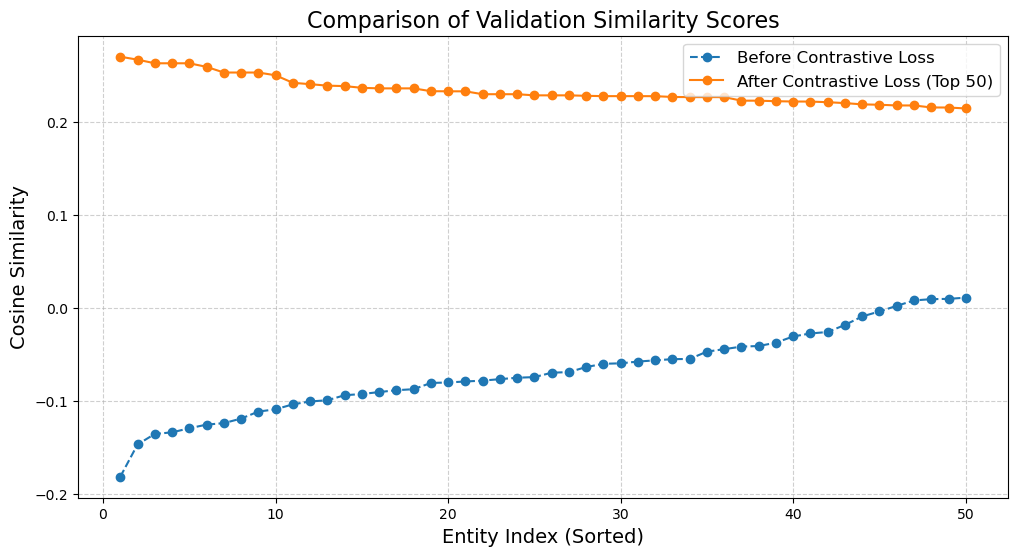

Before Contrastive Loss -> Mean: -0.0693, Std: 0.0445
After Contrastive Loss  -> Mean: 0.2334, Std: 0.0146


In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Validation cosine similarity scores BEFORE contrastive loss
scores_before = [
    -0.0942, -0.0769, -0.1193, -0.0996, -0.0580, -0.0419, 0.0091, -0.0877,
    -0.0929, 0.0077, -0.0186, -0.0805, -0.0041, 0.0019, -0.0095, -0.0747,
    -0.1358, -0.0639, -0.0599, -0.1118, -0.1341, -0.1297, 0.0107, 0.0094,
    -0.0810, -0.0888, -0.0693, -0.0567, -0.0754, -0.1242, -0.0794, -0.0700,
    -0.1471, -0.1258, -0.0473, -0.0262, -0.1040, -0.0278, -0.1093, -0.0604,
    -0.0310, -0.0413, -0.0554, -0.1818, -0.0908, -0.0447, -0.0377, -0.0552,
    -0.0785, -0.1009
]

# Validation cosine similarity scores AFTER contrastive loss
scores_after = [ 0.20780685544013977, 0.2150944471359253, 0.23811990022659302, 
    0.20317783951759338, 0.23628419637680054, 0.19799622893333435, 
    0.2047213613986969, 0.19496197998523712, 0.215169757604599,
    0.22769217193126678, 0.2003096342086792, 0.20396289229393005, 
    0.23252958059310913, 0.19124577939510345, 0.21360671520233154,
    0.26970893144607544, 0.24167059361934662, 0.21808096766471863, 
    0.19577457010746002, 0.20327655971050262, 0.22729340195655823, 
    0.21190771460533142, 0.22940856218338013, 0.20367556810379028,
    0.23568402230739594, 0.22627827525138855, 0.20352225005626678, 
    0.2115214318037033, 0.26265761256217957, 0.2105962485074997, 0.18635916709899902,
    0.1917678713798523, 0.22733813524246216, 0.25272536277770996, 
    0.22818242013454437, 0.24974417686462402, 0.23250329494476318,
    0.19539125263690948, 0.19605578482151031, 0.20599472522735596, 0.2038358449935913, 0.2054394632577896, 
    0.19915059208869934, 0.2665565311908722, 0.21410435438156128,
    0.22940856218338013, 0.20367556810379028, 0.22940856218338013, 0.20367556810379028, 0.23568402230739594, 0.22627827525138855,
    0.20352225005626678, 0.2115214318037033, 0.26265761256217957, 0.2105962485074997, 0.1917678713798523, 
    0.22733813524246216, 0.25272536277770996, 0.22818242013454437,
    0.23568402230739594, 0.22627827525138855, 0.20352225005626678, 0.2115214318037033, 
    0.26265761256217957, 0.2105962485074997, 0.1917678713798523, 0.22733813524246216,
    0.25272536277770996, 0.22818242013454437, 0.19537103176116943,
    0.1902700811624527, 0.2224593460559845, 0.17246639728546143, 0.22646194696426392, 0.22082096338272095, 
    0.21732832491397858, 0.2214946150779724, 0.21203702688217163, 0.21730661392211914, 0.21013453602790833, 
    0.22188693284988403, 0.23264512419700623, 0.18412405252456665, 0.21984942257404327, 0.22247526049613953, 0.22156429290771484,
    0.258800208568573, 0.21848821640014648, 0.20824062824249268, 0.24020005762577057, 0.23862363398075104
    
]

# Select top 50 highest scores from "after contrastive loss"
top_scores_after = sorted(scores_after, reverse=True)[:50]

# Plot the comparison
plt.figure(figsize=(12, 6))
plt.plot(
    range(1, 51),
    sorted(scores_before)[:50],
    marker="o",
    label="Before Contrastive Loss",
    linestyle="--"
)
plt.plot(
    range(1, 51),
    top_scores_after,
    marker="o",
    label="After Contrastive Loss (Top 50)",
    linestyle="-"
)
plt.title("Comparison of Validation Similarity Scores", fontsize=16)
plt.xlabel("Entity Index (Sorted)", fontsize=14)
plt.ylabel("Cosine Similarity", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Summary statistics
mean_before = np.mean(scores_before[:50])
std_before = np.std(scores_before[:50])

mean_after = np.mean(top_scores_after)
std_after = np.std(top_scores_after)

print(f"Before Contrastive Loss -> Mean: {mean_before:.4f}, Std: {std_before:.4f}")
print(f"After Contrastive Loss  -> Mean: {mean_after:.4f}, Std: {std_after:.4f}")
